In [78]:
# storia più su nns convolutive, capsulenetwork, evoluzione, problemi di classificazione





# usare affnist



# prova minst su affnist e verificare risultati con paper
# testare su dataset normale + rotraslato*2
# clustering per training
# risultato si su db normale sia rototraslato
#
# + provare no shearing


# matrice di confusione normalizzata sia su righe che su colonne (tot 3 matrici)

### Import statements

In [79]:
%%capture

import numpy as np
import tensorflow as tf
from datetime import datetime

# for affine transformation functions
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn
import torch
import math

# for loading affNIST_original
import scipy.io as spio

#for training progress bar
from tqdm import tqdm

#for image display
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# for performances functions
from numpy import sqrt 
import seaborn as sns
import pandas as pd

%cd /Users/paolobonomi/Work/Python/CapsNetwork

### CapsuleNetwork class

In [80]:
# input is 40x40x1
# conv1 is 32x32x256
# primCaps is 12x12x8x32
# W is 12x


class CapsuleNetwork40(tf.keras.Model):
    def __init__(self, no_of_conv_kernels, no_of_primary_capsules, primary_capsule_vector, no_of_secondary_capsules, secondary_capsule_vector, r):
        super(CapsuleNetwork40, self).__init__()
        self.no_of_conv_kernels = no_of_conv_kernels
        self.no_of_primary_capsules = no_of_primary_capsules
        self.primary_capsule_vector = primary_capsule_vector
        self.no_of_secondary_capsules = no_of_secondary_capsules
        self.secondary_capsule_vector = secondary_capsule_vector
        self.r = r
        
        with tf.name_scope("Variables") as scope:
            # creates convolutional layer with 256 9x9 kernels, stride 1, activation relu ( max(n,0) )
            # the model learns 256 9x9 filters and 256 biases
            # applies the filter then adds the bias and applies relu
                                                      # 256
            self.convolution = tf.keras.layers.Conv2D(self.no_of_conv_kernels, [9,9], strides=[1,1], name='ConvolutionLayer', activation='relu')
            
            # learns 32 * 8 (= 252) filters with kernel 9x9 and stride 2
                                                         #   32                       * 8
            self.primary_capsule = tf.keras.layers.Conv2D(self.no_of_primary_capsules * self.primary_capsule_vector, [9,9], strides=[2,2], name="PrimaryCapsule")
            
            # creates trainable tensor: shape=[1, 4608, 10, 16, 8])
            # there are 32 channels each of those has 144 (12*12) 8D capsule (12*12*32 = 1152 => 8D Vectors)
                                                                          #      10                             16                                 8
            self.w = tf.Variable(tf.random_normal_initializer()(shape=[1, 4608, self.no_of_secondary_capsules, self.secondary_capsule_vector, self.primary_capsule_vector]), dtype=tf.float32, name="PoseEstimation", trainable=True)
            
            # fully connected layers for image reconstruction
            self.dense_1 = tf.keras.layers.Dense(units = 512, activation='relu')
            self.dense_2 = tf.keras.layers.Dense(units = 1024, activation='relu')
            self.dense_3 = tf.keras.layers.Dense(units = 1600, activation='sigmoid', dtype='float32')
        
    def build(self, input_shape):
        pass

    def save(self, name, version, epochs):
        #  save the current trained module
        self.save_weights('saved_model/'+name+'_weights/capsule_network_weights'+'_epochs_'+str(epochs)+version)
    
    def load(self, name, version, epochs):
        self.load_weights('saved_model/'+name+'_weights/capsule_network_weights'+'_epochs_'+str(epochs)+version)
    
    def squash(self, s):
        with tf.name_scope("SquashFunction") as scope:
            s_norm = tf.norm(s, axis=-1, keepdims=True)
            return tf.square(s_norm)/(1 + tf.square(s_norm)) * s/(s_norm + epsilon)
    
    @tf.function
    def call(self, inputs):
        input_x, y = inputs
        # input_x.shape: (None, 40, 40, 1)
        # y.shape: (None, 10)
        
        x = self.convolution(input_x) #x.shape: (None, 32, 32, 256)
        x = self.primary_capsule(x) #x.shape: (None, 12, 12, 256) => 12*12*8*32 / 8 = 4608

        
        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], self.primary_capsule_vector)) # u.shape: (None, 4608, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 4608, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 4608, 1, 8, 1)
            
                                                  # w.shape: ( 1, 4608, 10, 16, 8 )
                                               # u.shape: ( None, 4608,  1,  8, 1 )
            u_hat = tf.matmul(self.w, u)   # u_hat.shape: ( None, 4608, 10, 16, 1 )
            u_hat = tf.squeeze(u_hat, [4])  # u_hat.shape: (None, 4608, 10, 16 )
        
        with tf.name_scope("DynamicRouting") as scope:
                                                       # 10                  
            b = tf.zeros((input_x.shape[0], 4608, self.no_of_secondary_capsules, 1)) # b.shape: (None, 4608, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 4608, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 4608, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 4608, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 4608, 10, 1, 1)
                b += agreement
                
        with tf.name_scope("Masking") as scope:
            y = tf.expand_dims(y, axis=-1) # y.shape: (None, 10, 1)
            y = tf.expand_dims(y, axis=1) # y.shape: (None, 1, 10, 1)
            mask = tf.cast(y, dtype=tf.float32) # mask.shape: (None, 1, 10, 1)
            v_masked = tf.multiply(mask, v) # v_masked.shape: (None, 1, 10, 16)
            
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(v_masked, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        
        return v, reconstructed_image
    
    @tf.function
    def predict_capsule_output(self, inputs):
        x = self.convolution(inputs) # x.shape: (None, 20, 20, 256)
        x = self.primary_capsule(x) # x.shape: (None, 12, 12, 256)
        
        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 4608, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 4608, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 4608, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 4608, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 4608, 10, 16)

        
        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((inputs.shape[0], 4608, self.no_of_secondary_capsules, 1)) # b.shape: (None, 4608, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 4608, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 4608, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement
        return v

    @tf.function
    def regenerate_image(self, inputs):
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(inputs, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        return reconstructed_image

### CapsuleNetwork functions

In [81]:
def safe_norm(v, axis=-1, epsilon=1e-7):
    v_ = tf.reduce_sum(tf.square(v), axis = axis, keepdims=True)
    return tf.sqrt(v_ + epsilon)

def predict(model, x):
    pred = safe_norm(model.predict_capsule_output(x))
    pred = tf.squeeze(pred, [1])
    return np.argmax(pred, axis=1)[:,0]

def loss_function(v, reconstructed_image, y, y_image):
    prediction = safe_norm(v)
    prediction = tf.reshape(prediction, [-1, no_of_secondary_capsules])
    left_margin = tf.square(tf.maximum(0.0, m_plus - prediction))
    right_margin = tf.square(tf.maximum(0.0, prediction - m_minus))
    l = tf.add(y * left_margin, lambda_ * (1.0 - y) * right_margin)
    margin_loss = tf.reduce_mean(tf.reduce_sum(l, axis=-1))
    y_image_flat = tf.reshape(y_image, [-1, 1600])
    reconstruction_loss = tf.reduce_mean(tf.square(y_image_flat - reconstructed_image))
    loss = tf.add(margin_loss, alpha * reconstruction_loss)
    
    return loss

def train(x,y):
    y_one_hot = tf.one_hot(y, depth=10)
    with tf.GradientTape() as tape:
        
        v, reconstructed_image = model([x, y_one_hot])
        loss = loss_function(v, reconstructed_image, y_one_hot, x)
        
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

def gerAccuracy():
    test_sum = 0
    for X_batch, y_batch in testing:
        
        test_sum += sum(predict(model, X_batch)==y_batch.numpy())

    print(test_sum/testing_dataset_size)
    
def train_for_epochs():
    losses = []
    accuracy = []
    for i in range(1, epochs+1, 1):

        loss = 0
        with tqdm(total=len(dataset)) as pbar:

            description = "Epoch " + str(i) + "/" + str(epochs)
            pbar.set_description_str(description)
            for X_batch, y_batch in dataset:

                loss += train(X_batch,y_batch)
                pbar.update(1)

            loss /= len(dataset)
            losses.append(loss.numpy())
            training_sum = 0
            print_statement = "Loss :" + str(loss.numpy()) + " Evaluating Accuracy ..."
            pbar.set_postfix_str(print_statement)
            for X_batch, y_batch in dataset:
                
                training_sum += sum(predict(model, X_batch)==y_batch.numpy())
            
            accuracy.append(training_sum/training_dataset_size)
            with file_writer.as_default():
                
                tf.summary.scalar('Loss', data=loss.numpy(), step=i)
                tf.summary.scalar('Accuracy', data=accuracy[-1], step=i)

            print_statement = "Loss :" + str(loss.numpy()) + " Accuracy :" + str(accuracy[-1])
            pbar.set_postfix_str(print_statement)
            
            
            
            ################################# CHECKPOINT FOR TRAINING
            
            
    
            #if i % 10 == 0: 
            #    checkpoint.save(checkpoint_path)
            
            
            

### Custom AffNIST transformation functions

1) the amount of counter-clockwise rotation, in degrees. This is chosen uniformly between -20 and +20.

2) the amount of shearing. Shearing is applied to coordinates by adding x*shearing to the y coordinate. Thus, a shearing factor of 1 means that a horizontal line turns into a line at 45 degrees. The shearing factor is chosen uniformly between -0.2 and +0.2.

3) the vertical expansion and the horizontal expansion. These are chosen uniformly between 0.8 (i.e. shrinking the digit image by 20%) and 1.2 (i.e. making the image 20% larger).

4) the vertical translation and the horizontal translation. These are only restricted by the requirement that no ink must fall off the 40x40 image, and can therefore be quite large.

In [82]:
def show(x, y, size):
    plt.figure()
    plt.xlabel(y)
    plt.imshow(tf.reshape(x, [1, size, size, 1])[0])

def get_pads(i, j, size):
    pad_i = (size-i)/2
    if (pad_i%2) != 0 :
        pad_i_s = int(math.floor(pad_i))
        pad_i_f = int(math.ceil(pad_i))
    else:
        pad_i_s = int(pad_i)
        pad_i_f = int(pad_i)
        
    pad_j = (size-j)/2
    if (pad_j%2) != 0 :
        pad_j_s = int(math.floor(pad_j))
        pad_j_f = int(math.ceil(pad_j))
    else:
        pad_j_s = int(pad_j)
        pad_j_f = int(pad_j)
    
    return pad_i_s, pad_i_f, pad_j_s, pad_j_f

def check_bounds(img, size):
    for i in range(0, size):
        if ( img[0][i][0] > 0 ) or ( img[0][i][size-1] > 0 ) or ( img[0][0][i] > 0 ) or ( img[0][size-1][i] > 0 ) :
            return False
        
def apply_random_affine_transformation(img, size):
    rotation = 20.0
    shear = (-9.0, 9.0, -9.0, 9.0)
    scaling = [0.8, 1.2]
    translation = 0 # no ink can fall outside
        
    rx = np.reshape(img, [1, 28, 28])
    rx = torch.from_numpy(rx)
            
    #APPLY SCALING
    i = math.ceil( np.random.uniform(28*scaling[0], 28*scaling[1]) )
    j = math.ceil( np.random.uniform(28*scaling[0], 28*scaling[1]) )
    rx = fn.resize(rx, size=[ i, j ], interpolation=transforms.InterpolationMode.NEAREST)
    
    ## APPLY PADDING
    pad_i_s, pad_i_f, pad_j_s, pad_j_f = get_pads(i, j, size)
    rx = np.pad(rx[0], ( ( pad_i_s, pad_i_f ), ( pad_j_s, pad_j_f ) ) )
    
    ## RESHAPE
    rx = np.reshape(rx, [1, 40, 40])
    
    ## APPLY OTHER TRANSFORMATION
    rx = torch.from_numpy(rx)
    
    flag = True
    while flag: 
        tx = transforms.RandomAffine(rotation, (0, 0.1), (1, 1), shear)
        rx_ = tx(rx)
        flag = check_bounds(rx_, size)
    
    rx_ =  tf.convert_to_tensor(rx_, dtype=tf.dtypes.float32)

    return rx_ 

def apply_affine(tensor, description):
    #shape (60000, 28, 28)
    
    n = tensor.shape[0]
    images = list()
    
    with tqdm(total=(n/100)) as pbar:
        
        pbar.set_description_str(description)
        
        for i in range(0, n):
            img = apply_random_affine_transformation(tensor[i, :, :], 40)
            images.append(img[0])
            if i % 100 == 0:
                pbar.update(1)
        
        pbar.set_postfix_str("")
        
    result = tf.stack(images)
    return result

def create_custom_affnist(train):
    if train:
        print("Load MIST dataset from keras... ")
        (X_, y_), (X_test , y_test)= tf.keras.datasets.mnist.load_data()
        print("Apply affine transformations... ")
        X_ = apply_affine(X_, "Apply transformation on train set")
        print("Saving dataset... ")
        np.save('./notebook/data/affNIST/x_train'+database_version+'.npy', X_)
        np.save('./notebook/data/affNIST/y_train'+database_version+'.npy', y_)
    else:
        print("Load MIST dataset from keras... ")
        (X_train, y_train), (X_ , y_)= tf.keras.datasets.mnist.load_data()
        print("Apply affine transformations... ")
        X_ = apply_affine(X_, "Apply transformation on test set")
        print("Saving dataset... ")
        np.save('./notebook/data/affNIST/x_test'+database_version+'.npy', X_)
        np.save('./notebook/data/affNIST/y_test'+database_version+'.npy', y_)

    return X_, y_  

### affNIST loading functions

In [83]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)


def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        


def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

def load_test_affNIST():
    path = './notebook/data/affNIST_Official/test_batches/1.mat'
    dataset = loadmat(path) 

    ans_set = dataset['affNISTdata']['label_int'] # (10'000)
    test_set = dataset['affNISTdata']['image'] # (1'600, 10'000)

    return test_set,ans_set

def load_train_affNIST():
    path = './notebook/data/affNIST_Official/training_batches/1.mat'
    dataset = loadmat(path)

    ans_set = dataset['affNISTdata']['label_int'] # (10'000)
    train_set = dataset['affNISTdata']['image'] # (1'600, 50'000)

    return train_set,ans_set

### switch database functions

In [84]:
def switch_dataset(string, train):
    X_ = 0
    y_ = 0
    
    if string == dataset_keys[0]: # MINST
        
        if(train):
            
            print("Load MINST train dataset from keras... ")
            (X_, y_), (X_test , y_test)= tf.keras.datasets.mnist.load_data()
            
        else:
            
            print("Load MINST test dataset from keras... ")
            (X_train, y_train), (X_ , y_)= tf.keras.datasets.mnist.load_data()
            
    elif string == dataset_keys[1]: # CUSTOM AFFNIST
        
        if(should_create_dataset):
            
            (X_, y_) = create_custom_affnist(train)
            
        else:
            
            if(train):
            
                print("Load Custom AffNIST train dataset... ")
                X_ = np.load('./notebook/data/affNIST/x_train'+database_version+'.npy')
                y_ = np.load('./notebook/data/affNIST/y_train'+database_version+'.npy')

            else:   
                
                print("Load Custom AffNIST test dataset... ")
                X_ = np.load('./notebook/data/affNIST/x_test'+database_version+'.npy')
                y_ = np.load('./notebook/data/affNIST/y_test'+database_version+'.npy')
                
    elif string == dataset_keys[2]: # AFFNIST
        
        if(train):
            
            print("Load AffNIST train dataset... ")
            (X_, y_) = load_train_affNIST()
            
        else:
            
            print("Load AffNIST test dataset... ")
            (X_, y_) = load_test_affNIST()
    
    return X_, y_

model_keys = ["M", "M40", "CA", "A", "CAWS"]

### Train/Load the model

In [85]:
dataset_keys = ["MNIST", "CUSTOM_AFFNIST", "AFFNIST"]
model_keys = ["M40", "CA", "A", "CAWS"]

train_dataset_setting = dataset_keys[1]
test_dataset_setting = dataset_keys[1]

model_settings = model_keys[1]

database_version = "_v1" # for custom affnist
model_version = "_v1"


should_be_trained = False
epochs = 10

should_create_dataset = False


### todo to change

In [86]:
#%%capture

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

##################### DEFINE PARAMETERS

BATCH_SIZE = 64
epsilon = 1e-7
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5
alpha = 0.0005
no_of_secondary_capsules = 10
optimizer = tf.keras.optimizers.Adam()
params = {
    "no_of_conv_kernels": 256,
    "no_of_primary_capsules": 32,
    "no_of_secondary_capsules": 10,
    "primary_capsule_vector": 8,
    "secondary_capsule_vector": 16,
    "r":3,
}

################################# SUMMARY FOR TENSORBOARD



#stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = './logs/func/%s' % stamp
#writer = tf.summary.create_file_writer(logdir)
#scalar_logdir = './logs/scalars/%s' % stamp
#file_writer = tf.summary.create_file_writer(scalar_logdir + "/metrics")
#tf.summary.trace_on(graph=True, profiler=True)



################################# checkpoint for training



#checkpoint = tf.train.Checkpoint(model=model)
#checkpoint_path = './logs/model/capsule'



################################# DATASET

(X_train, y_train) = switch_dataset(train_dataset_setting, train=True)
(X_test, y_test) = switch_dataset(test_dataset_setting, train=False)

print("Processing dataset... ")

X_train = X_train / 255.0
X_train = tf.cast(X_train, dtype=tf.float32)
X_train = tf.expand_dims(X_train, axis=-1)

X_test = X_test / 255.0
X_test = tf.cast(X_test, dtype=tf.float32)
X_test = tf.expand_dims(X_test, axis=-1)

testing_dataset_size = X_test.shape[0]
training_dataset_size = X_train.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size=BATCH_SIZE)

testing = tf.data.Dataset.from_tensor_slices((X_test, y_test))
testing = testing.batch(batch_size=BATCH_SIZE)



################################# CREATE MODEL


print("Creating model... ")

model = CapsuleNetwork40(**params)

if(should_be_trained):

    print("Start training model...")
    train_for_epochs()

    print("Saving model... ")
    model.save(model_settings, model_version, epochs)
else:

    print("Loading model... ")
    model.load(model_settings, model_version, epochs)
    _ = train(X_train[:32],y_train[:32])
    
################################# SUMMARY FOR TENSOR BOARD



#with writer.as_default():
#    tf.summary.trace_export(name="my_func_trace", step=0, profiler_outdir=logdir) 
#tf.summary.trace_off()
#model.summary()




Found GPU at: /device:GPU:0
Load Custom AffNIST train dataset... 


2022-10-20 17:05:39.611710: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-20 17:05:39.611836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Load Custom AffNIST test dataset... 
Processing dataset... 
Creating model... 
Loading model... 


2022-10-20 17:05:40.869549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-20 17:05:43.842991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [88]:
print(dataset[0])

TypeError: 'BatchDataset' object is not subscriptable

### Performance Analizying Functions

In [67]:
headers = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

def get_confusion_table_for(mat, digit, tot):
    
    dict_ = {}
    
    # condition positive (how many images were < digit >)
    p = 0
    for i in range(0, 10):
        p += mat[i, digit]
    dict_["Condition Positive"] = p
    
    #condition negative (how many images were not < digit > )
    n = tot - p
    dict_["Condition Negative"] = n 
    
    tp = mat[digit, digit]
    dict_["True Positive (TN)"] = tp
    
    fn = -tp
    for i in range(0, 10):
        fn += mat[i, digit]
    dict_["False Negative (FN)"] = fn
    
    fp = -tp
    for i in range(0, 10):
        fp += mat[digit, i]
    dict_["False Positive (FP)"] = fp 
    
    tn = tot + tp    
    for i in range(0, 10):
        tn -= mat[digit, i] + mat[i, digit]
    dict_["True Negative (TN)"] = tn 

    tpr = tp / p
    dict_["Sensitivity (TPR)"] = tpr 

    tnr = tn / n
    dict_["Specificity (TNR)"] = tnr 

    ppv = tp / (tp + fp)
    dict_["Positive Predictive Value (PPV)"] = ppv

    npv = tn / ( tn + fn )
    dict_["Negative Predictive Value (NPV)"] = npv 

    fnr = 1 - tpr
    dict_["False Negative Rate (FNR)"] = fnr 

    fpr = 1 - tnr
    dict_["False Positive Rate (FPR)"] = fpr 

    fdr = 1 - ppv
    dict_["False Discovery Rate (FDR)"] = fdr 

    for_ = 1 - npv
    dict_["False Omission Rate (FOR)"] = for_ 

    lr_p = tpr/fpr
    dict_["Positive Likelihood Ratio (LR+)"] = int(lr_p) 
    
    lr_n = fnr/tnr
    dict_["Negative Likelihood Ratio (LR-)"] = lr_n 

    pt = sqrt( fpr ) / ( sqrt(tpr) * sqrt(fpr) )
    dict_["Prevalence Threshold (PT)"] = pt 

    ts = tp / ( tp + fn + fp )
    dict_["Threat Score"] = ts 

    prevalence = p / tot
    dict_["Prevalence"] = prevalence 
    
    acc = ( tp + tn ) / tot
    dict_["Accuracy (ACC)"] = acc 

    ba = ( tpr * tnr ) / 2
    dict_["Balanced Accuracy"] = ba 

    f1 = ( 2*tp ) / ( 2*tp + fp + fn )
    dict_["F1 Score"] = f1 

    mcc = ( ( tp * tn ) - ( fp * fn ) ) / sqrt( ( tp+fp )*( tp*fn )*( tn+fp )*(tn+fn) )
    dict_["Matthews Correlation Coefficient (MCC)"] = mcc
    
    fm = sqrt( ppv * tpr )
    dict_["Fowlkes–Mallows Index (FM)"] = fm
    
    bm = tpr + tnr - 1
    dict_["Bookmaker Informedness (BM)"] = bm
    
    mk = ppv + npv - 1
    dict_["Markedness (MK)"] = mk
    
    #from 0 to inf
    dor = lr_p / lr_n
    dict_["Diagnostic odds ratio (DOR)"] = int(dor)
    
    header = np.array(list(dict_.keys()))
    values = np.array(list(dict_.values()))
    
    return values, header

def get_accuracy(matrix):
    a = 0        
    for i in range(0, 10):        
        a += matrix[i, i]
    
    return a

def get_confusion_mat(predict_function, model, data, name):
    matrix = np.zeros((10,10))
    
    with tqdm(total=len(data)) as pbar:
        
        description = "Creating "+name+" confusion matrix"
        pbar.set_description_str(description)
        for X_batch, y_batch in data:
            
            res = predict_function(model, X_batch)
            for i in range(0, y_batch.shape[0]):
                
                matrix[y_batch[i], res[i]] += 1 # row, col
        
            pbar.update(1)

    return matrix

def normalize_matrix(matrix, tot):
    mat = matrix.copy()
    for i in range(0, 10):
        for j in range(0, 10):
            mat[i, j] = (mat[i, j] / tot) * 100  
    return mat

def print_eval_params(mat):
    
    tot_in = 0
    tot_out = 0
    
    for j in range(0, 10):
        digit = j
        
        v = 0
        for i in range(0, 10):
            v += mat[digit, i]
        k = mat[digit, digit]
        tot_out += (k/v)
        r = (k/v)*100
        
        
        #the model has predict digit v times, k of that was right
        #osservo l'output, qual'è la probabilità che il modello abbia classificato in modo corretto?
        print("Proportion of digit < "+str(digit)+" > that was correctly identified =\t\t"+str(r)+"%") #sommo sulla riga

        v = 0
        for i in range(0, 10):
            v += mat[i, digit]  
        k = mat[digit, digit]
        tot_in += (k/v)
        r = (k/v)*100
        
        #the environment has shown digit v times, the model has predicted it k times
        #osservo l'input, qual'è la probabilità che venga classificato correttamente? 
        print("Proportion of actual digit < "+str(digit)+" > which is correctly identified =\t"+str(r)+"%") #sommo sulla colonna
        
        print("")

    print("Average observation correctness respect to ouput = "+str(tot_out*10))
    print("Average observation correctness respect to input = "+str(tot_in*10))

def print_matrix(matrix, title, x_label, y_label, x_headers, y_headers, size_x=10, size_y=10, color="Blues"):
    fig, ax = plt.subplots(figsize=(size_x,size_y))
    ax = sns.heatmap(matrix, annot=True, fmt='g', cmap=color, ax=ax)
        
    ax.set_title(title+'\n\n', size=size_x*1.9);
    ax.set_xlabel('\n'+x_label, size=size_x*1.5)
    ax.set_ylabel(y_label+' \n', size=size_x*1.5);


    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 2, 4, 6, 8, 10])
    colorbar.set_ticklabels(['0%', '2%', '4%', '6%', '8%', '10%'])

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(x_headers)
    ax.yaxis.set_ticklabels(y_headers)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
def trim(string):
    if string.endswith(".0"):
        return string[0:-2]
    return string
    
def print_confusion_tables(confusion_matrix, dataset_size):
    values = []
    index = []
    columns = []
    for i in range(0, 10):
        v, h = get_confusion_table_for(confusion_matrix, i, dataset_size)
        values.append(v)
        index = h
        columns.append(i)
    
    values = np.around(np.array(values), decimals=3)
    index = np.array(index)
    columns = np.array(columns)

    df = pd.DataFrame( values , index=columns, columns=index, dtype=str).T
    df.columns.name = "Digit"
    df = df.applymap(trim)
    return df 

### SHOW RESULT

In [68]:
should_create_matrix = False

In [69]:
if should_create_matrix:
    confusionmatrix_test = get_confusion_mat(predict, model, testing, "test")
    %store confusionmatrix_test
    
    confusionmatrix_train = get_confusion_mat(predict, model, dataset, "train")
    %store confusionmatrix_train
else:
    %store -r confusionmatrix_train
    %store -r confusionmatrix_test 
    
acc_train = get_accuracy(normalize_matrix( confusionmatrix_train, training_dataset_size))
acc_test = get_accuracy(normalize_matrix( confusionmatrix_test, testing_dataset_size))

#### Confusion Table

In [70]:
print_confusion_tables(confusionmatrix_test, testing_dataset_size)

Digit,0,1,2,3,4,5,6,7,8,9
Condition Positive,1038,1149,1017,1066,973,888,914,1058,900,997
Condition Negative,8962,8851,8983,8934,9027,9112,9086,8942,9100,9003
True Positive (TN),976,1123,982,997,941,840,901,998,883,942
False Negative (FN),62,26,35,69,32,48,13,60,17,55
False Positive (FP),4,12,50,13,41,52,57,30,91,67
True Negative (TN),8958,8839,8933,8921,8986,9060,9029,8912,9009,8936
Sensitivity (TPR),0.94,0.977,0.966,0.935,0.967,0.946,0.986,0.943,0.981,0.945
Specificity (TNR),1,0.999,0.994,0.999,0.995,0.994,0.994,0.997,0.99,0.993
Positive Predictive Value (PPV),0.996,0.989,0.952,0.987,0.958,0.942,0.941,0.971,0.907,0.934
Negative Predictive Value (NPV),0.993,0.997,0.996,0.992,0.996,0.995,0.999,0.993,0.998,0.994


#### Confusion Matrix

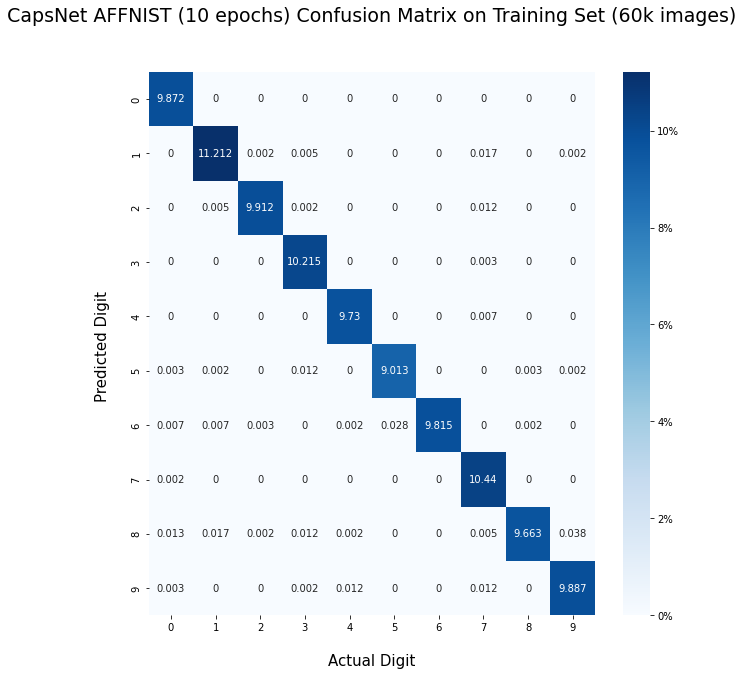

In [71]:
print_matrix(
    np.around(normalize_matrix( confusionmatrix_train, training_dataset_size), decimals=3),
    'CapsNet AFFNIST (10 epochs) Confusion Matrix on Training Set ('+str(int(training_dataset_size/1000))+'k images)',
    'Actual Digit',
    'Predicted Digit',
    headers,
    headers)

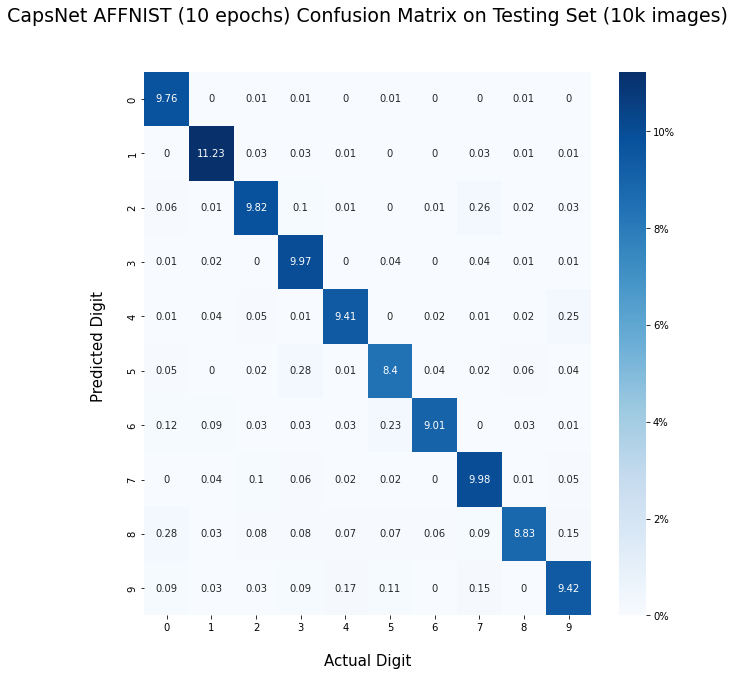

In [72]:
print_matrix(
    np.around(normalize_matrix( confusionmatrix_test, testing_dataset_size), decimals=3),
    'CapsNet AFFNIST (10 epochs) Confusion Matrix on Testing Set ('+str(int(testing_dataset_size/1000))+'k images)',
    'Actual Digit',
    'Predicted Digit',
    headers,
    headers)

#### Accuracy

In [73]:
d = {
    "Accuracy" : [np.around(acc_train, decimals=3), np.around(acc_test, decimals=3)],
    "# Images" : [training_dataset_size, testing_dataset_size],
    "Epochs" : [10, 10]
}

pd.DataFrame(d, index=["Train", "Test"])

,Accuracy,# Images,Epochs
Train,99.758,60000,10
Test,95.830,10000,10


### CHECK ERRORS

In [74]:
def show_prediction(img):
    x = X_test[:img+1]
    y = y_test[:img+1]
    
    image = x[img]
    label = y[img]
    rx = tf.reshape(image, [1, 40, 40, 1])
    ry = tf.reshape(label, [1,] )
    p = predict(model, rx)[0]
    
    plt.figure()
    plt.xlabel("value: "+str(ry.numpy()[0])+" - prediction: "+str(p)) #label
    plt.imshow(rx[0])
    
def get_error_index(start, stop):
    error = list()
    for i in range (start, stop):
        x = X_test[:i+1]
        y = y_test[:i+1]
        rx = tf.reshape(x[i], [1, 40, 40, 1])
        p = predict(model, rx)[0]
        if p!=y[i]:
            error.append(i)

    return error

def show_grid(x, dimx, dimy, title, size=20.):
    fig = plt.figure(figsize=(size, size))
    fig.suptitle(title, fontsize=16)
    grid = ImageGrid( fig, 111,nrows_ncols=(dimy, dimx),axes_pad=0.1, )
    a = []

    for i in range(dimx*dimy):
        j = x[:, :, i]
        a.append(j)

    for ax, im in zip(grid, a):
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.imshow(im, cmap="gray")

    fig.subplots_adjust(top=0.97) 
    plt.show()

def show_fixed_network_params():
    f = model.layers[0].get_weights()[0] # f.shape: (9, 9, 1, 256)
    show_grid(f[:,:,0,:], 16, 16, "Conv1 256 filters") # show filters
    
    f = model.layers[1].get_weights()[0] # f.shape: (9, 9, 256, 256)
    show_grid(f[:,:,:,0], 16, 16, "Primary Capsule Filter 9x9x256 #1 of 32*8") # first filter 9x9x256
    show_grid(f[:,:,:,0], 16, 16, "Primary Capsule Filter 9x9x256 #2 of 32*8") # first filter 9x9x256
    show_grid(f[:,:,:,0], 16, 16, "Primary Capsule Filter 9x9x256 #3 of 32*8") # first filter 9x9x256    
    
def show_conv1_rfm(x, f, b, img):
    rx = np.array(tf.reshape( x[img], [1, 40, 40, 1]))
    rx = tf.nn.conv2d(rx,f,strides=[1, 1],padding='VALID')
    rx = tf.add(rx, b)
    rx = tf.nn.relu(rx).numpy()
    show_grid(rx[0], 16, 16, "Conv1 256 output 32x32x256")
    
def show_prim_caps_rfm(x, f, b, img):
    rx = np.array(tf.reshape( x[img], [1, 32, 32, 256]))
    rx = tf.nn.conv2d(rx,f,strides=[2, 2],padding='VALID')
    rx = tf.add(rx, b)
    show_grid(rx[0], 8, 32, "Primary Capsule 12x12x8 output, each row is a channel (32 total)", 40.)

def show_network(img):    
    #----------------------------------------------------- INPUT

    x = X_test[:img+1]
    y = y_test[:img+1]
    show_prediction(img) # show prediction

    #-------------------------------------------------------- CONV1

    # filters
    f = model.layers[0].get_weights()[0]
    # biases
    b = model.layers[0].get_weights()[1]

    
    show_conv1_rfm(x, f, b, img) # show reconstructed feature maps

    #-------------------------------------------------------- OUTPUT

    x = model.convolution(x)

    #-------------------------------------------------------- PRIMARY CAPSULE

    f = model.layers[1].get_weights()[0]
    b = model.layers[1].get_weights()[1]
    
    show_prim_caps_rfm(x, f, b, img) # shows recostructed feature maps

    #-------------------------------------------------------- OUTPUT

    x = model.primary_capsule(x)

2022-10-20 12:33:22.807435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


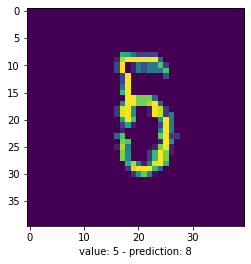

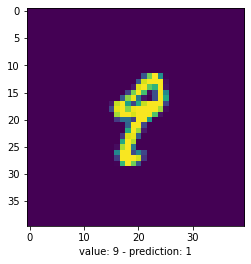

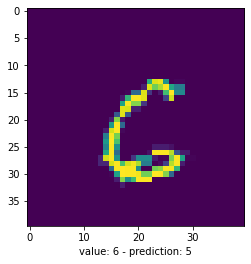

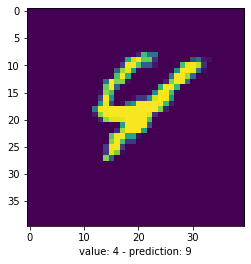

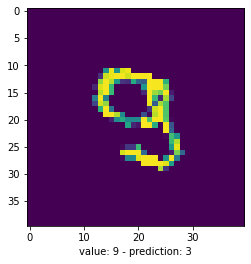

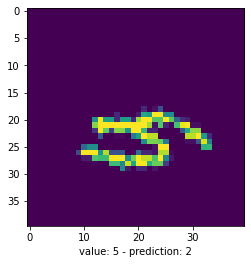

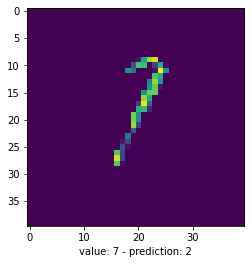

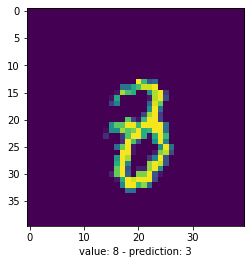

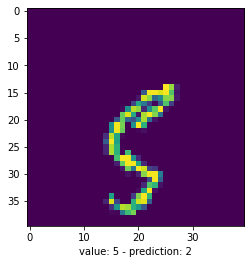

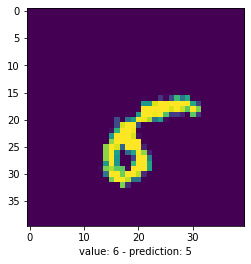

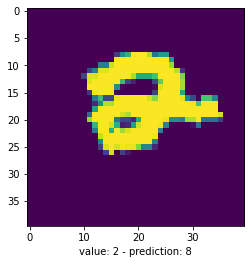

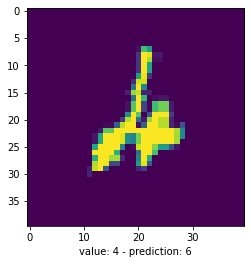

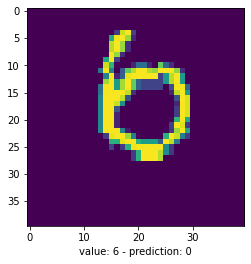

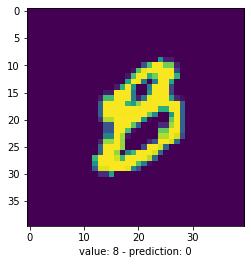

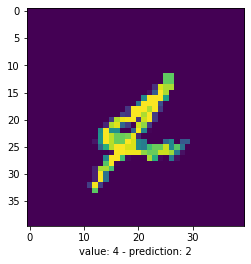

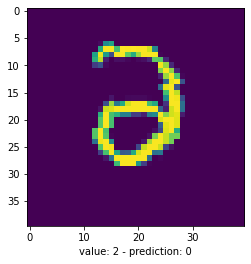

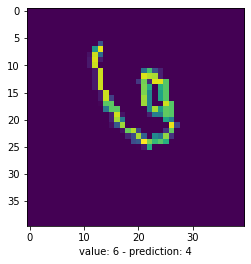

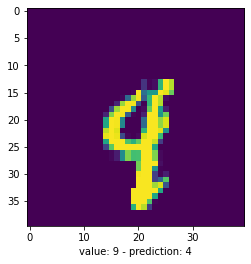

In [75]:
errors = [45, 78, 98, 139, 151, 167, 175, 184, 211, 217, 222, 247, 259, 266, 300, 318, 341, 359]

for i in errors:
    show_prediction(i)


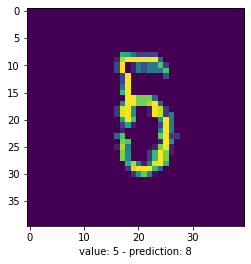

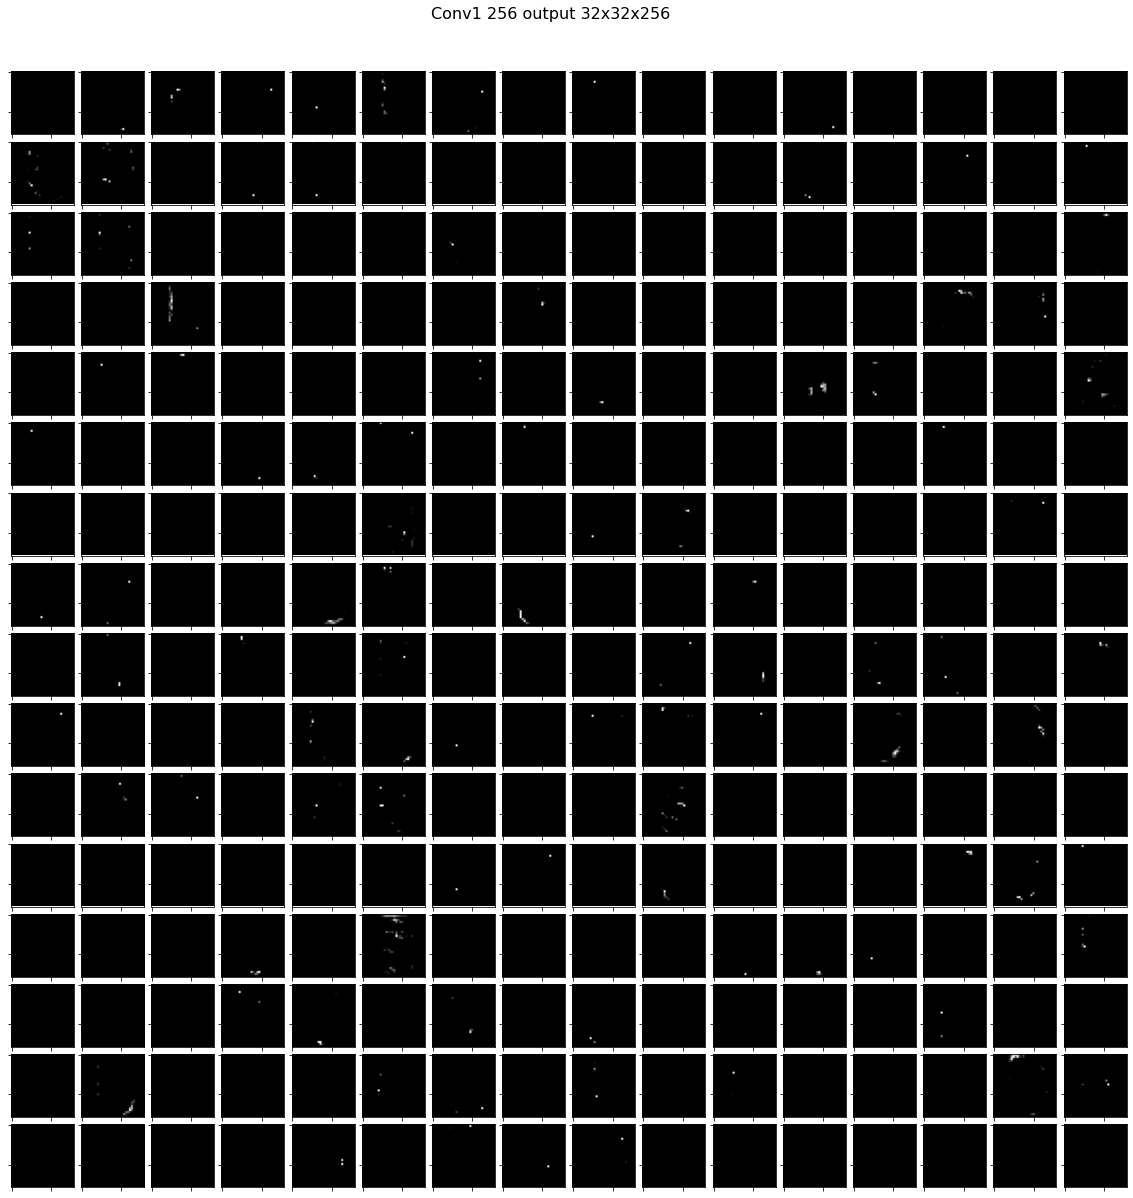

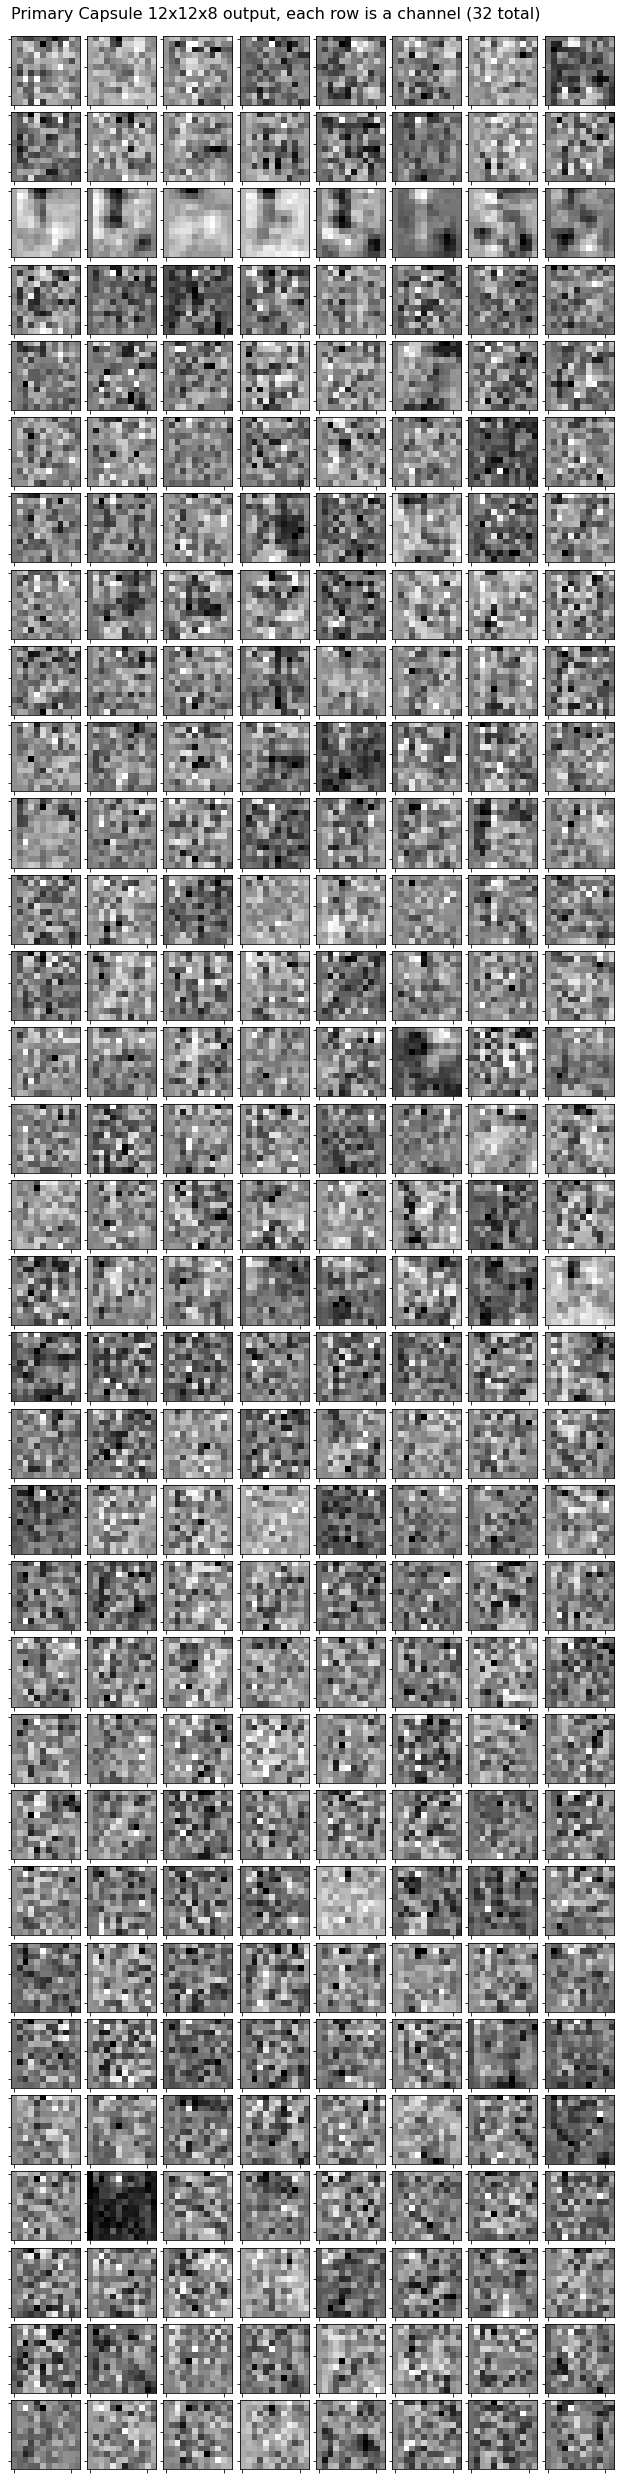

In [76]:
show_network(45)

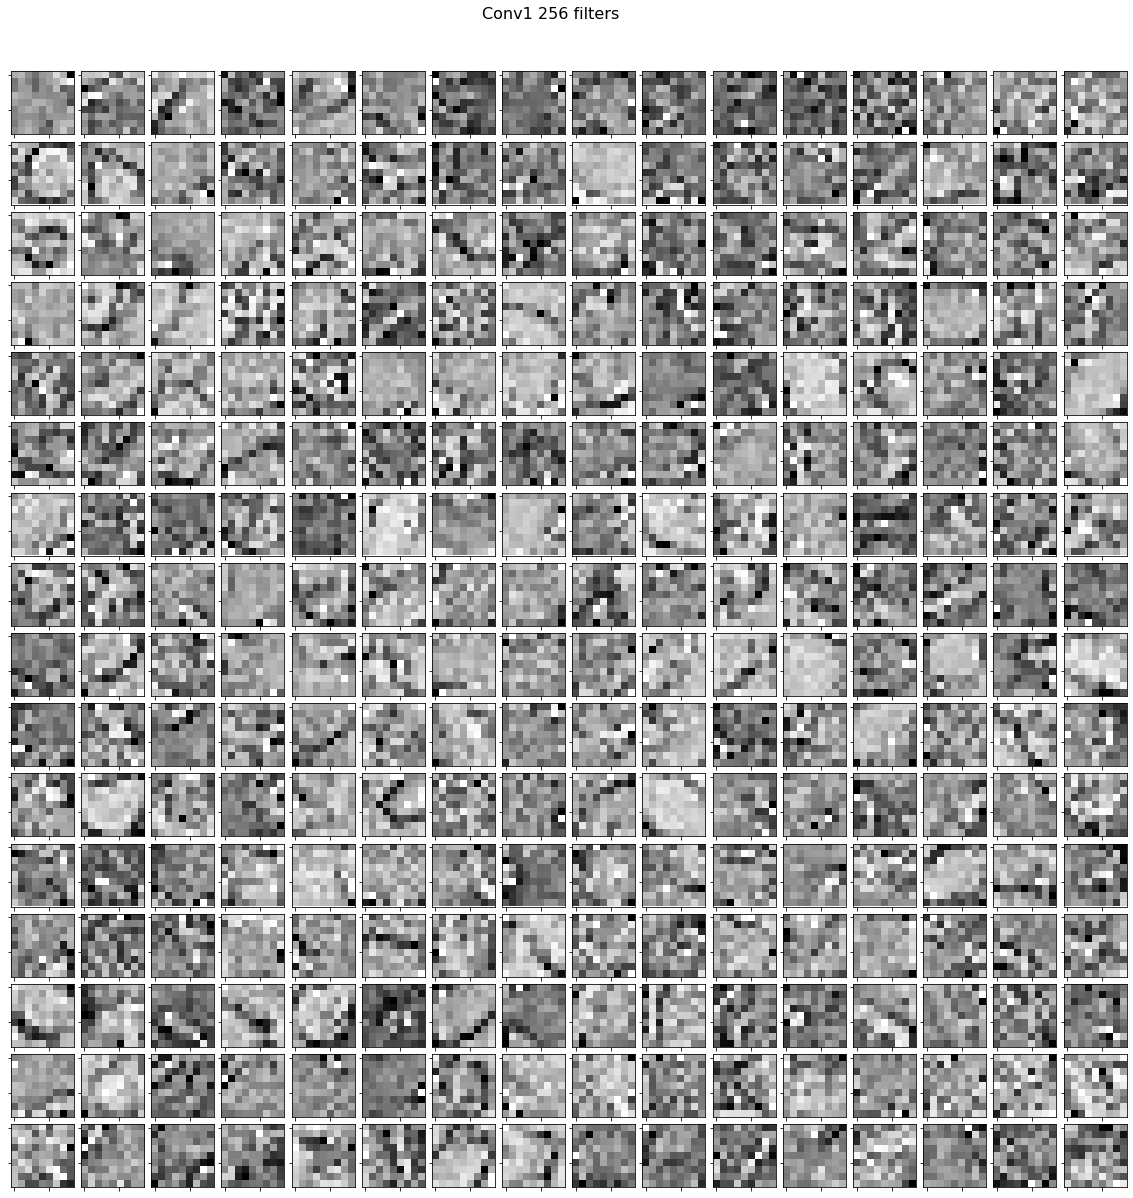

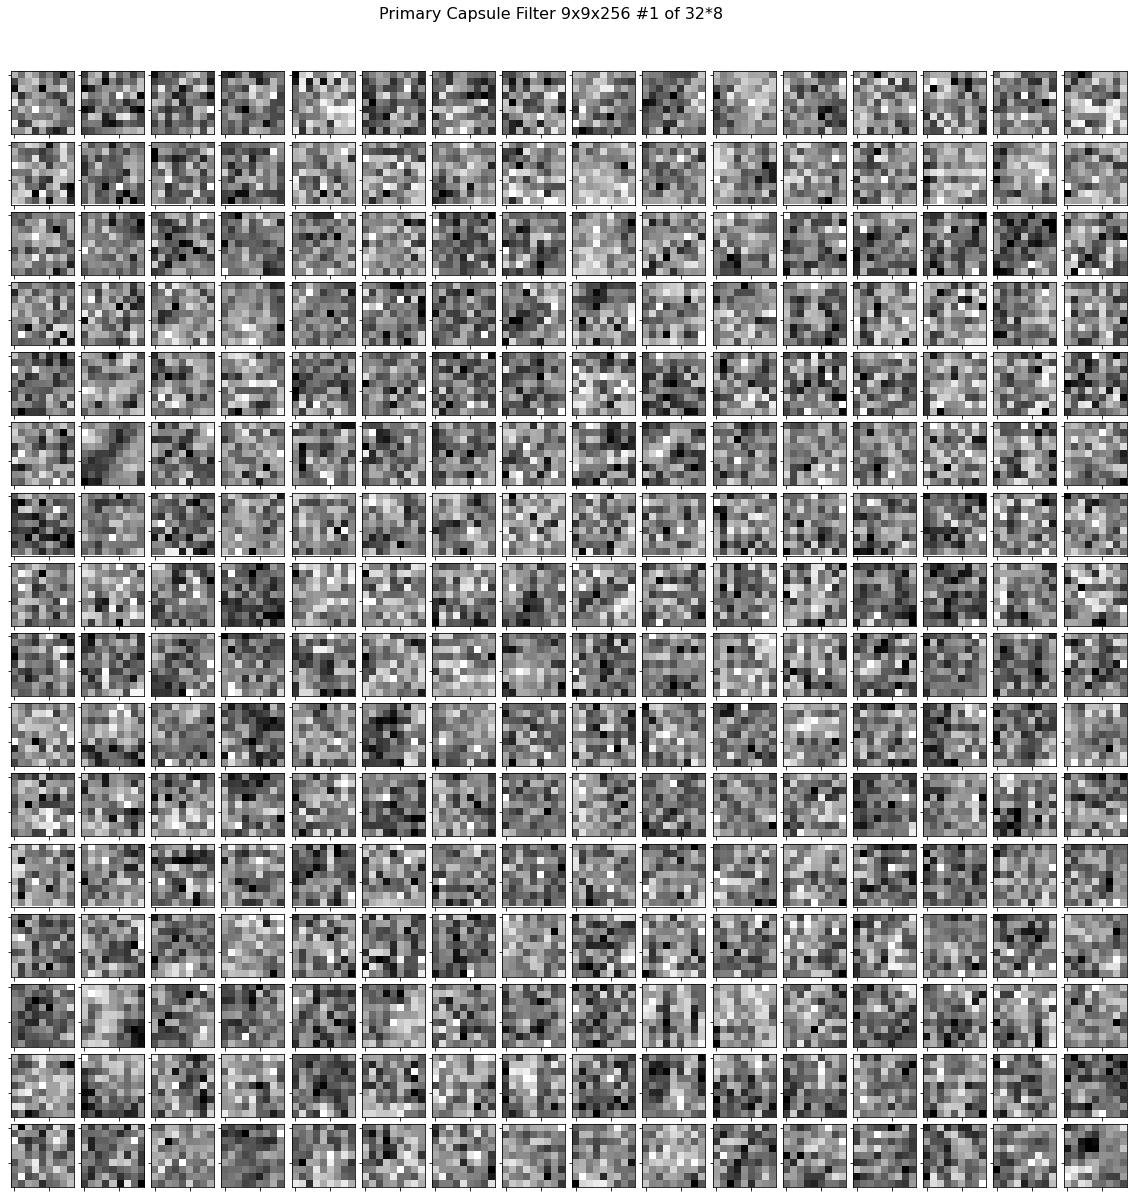

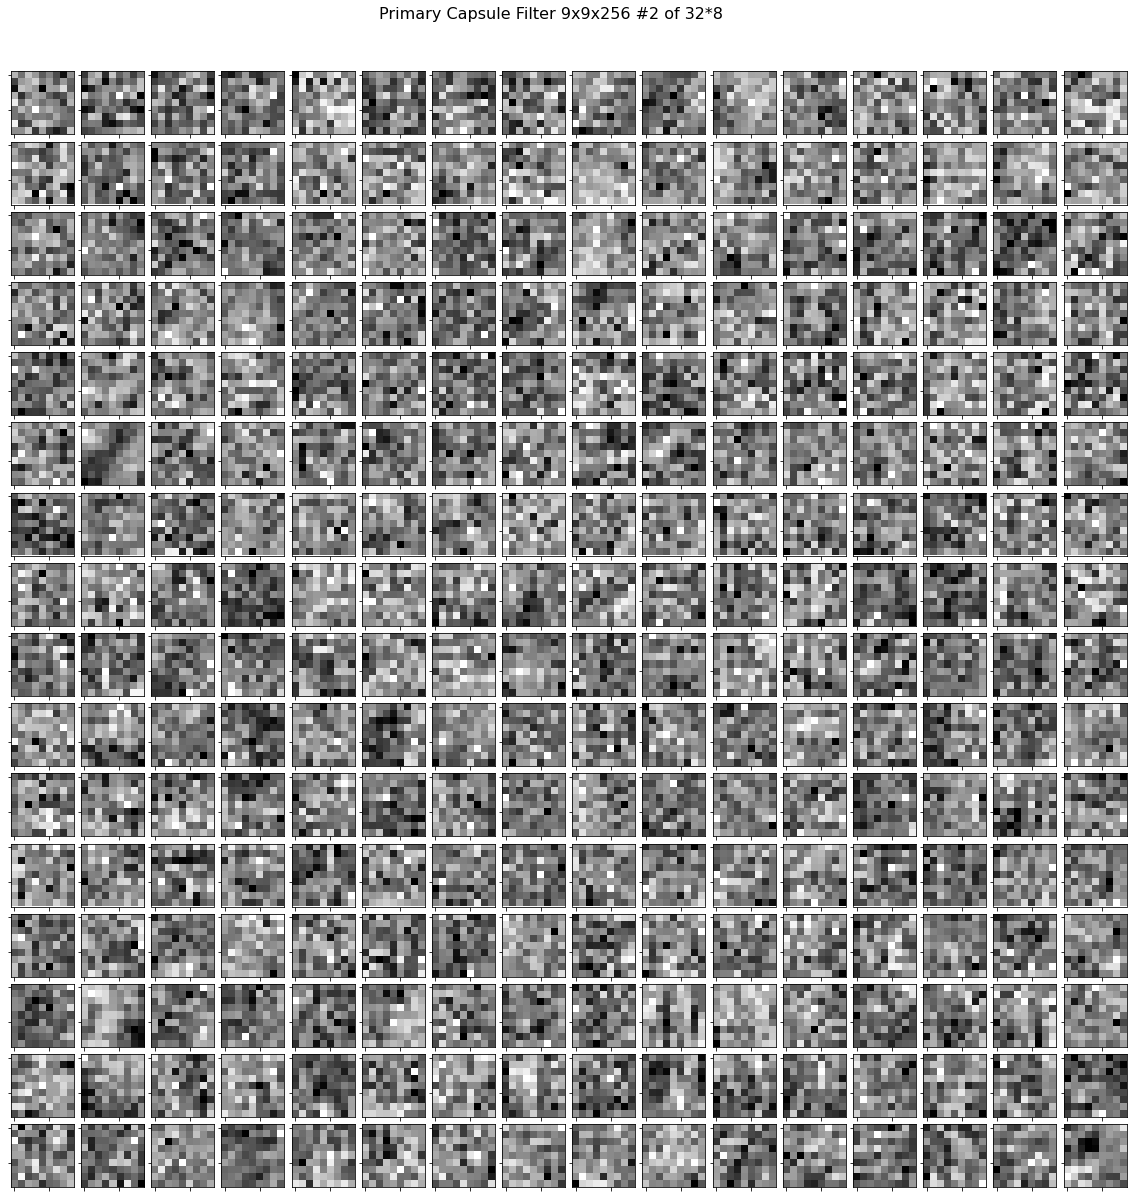

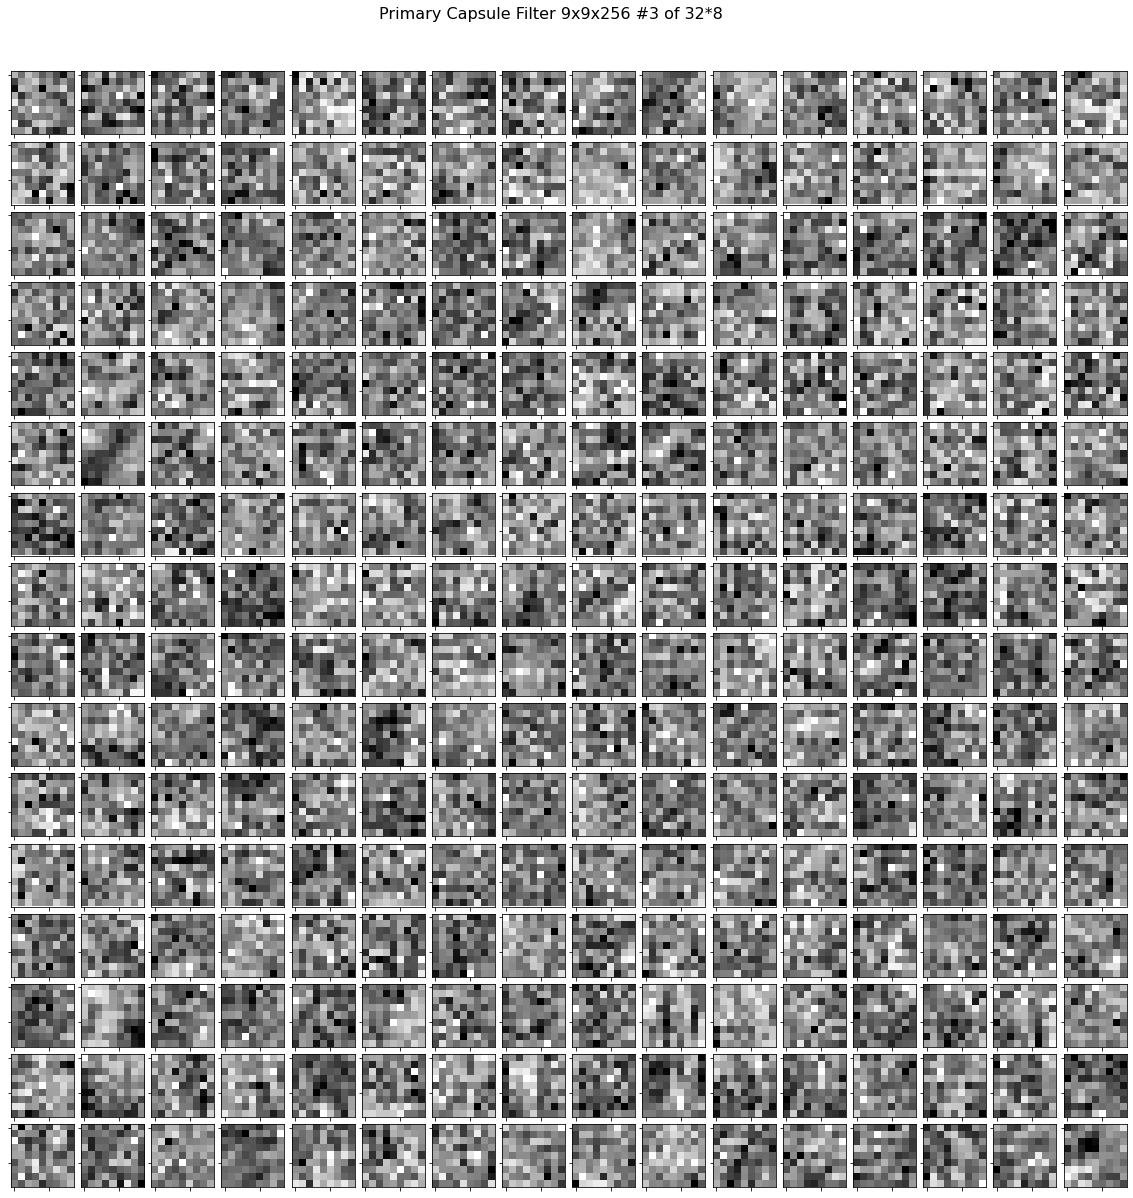

In [77]:
show_fixed_network_params()